# Classification. Linear models and KNN

In [812]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

In [813]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [814]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [815]:
PATH = "./data/"

In [816]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [817]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [818]:
female, male = data[(data['Sex'] == 'female')].shape[0], data[(data['Sex'] == 'male')].shape[0]
print(' Number of woman:', female, '\n', 'Number of male:', male)

 Number of woman: 314 
 Number of male: 577


In [819]:
surv, not_surv = data[(data['Survived'] == 1)].shape[0], data[(data['Survived'] == 0)].shape[0]
print(' Number of survivors:', surv, '\n', 'Number of not survivors:', not_surv)

 Number of survivors: 342 
 Number of not survivors: 549


In [820]:
surv_female, surv_male = data[((data['Sex'] == 'female') & (data['Survived'] == 1))].shape[0], data[(data['Sex'] == 'male') & (data['Survived'] == 1)].shape[0]
print(' Number of women who survived:', surv_female, '\n', 'Number of male who survived:', surv_male)

 Number of women who survived: 233 
 Number of male who survived: 109


In [821]:
# Процент выживших женщин.
sfp = surv_female / female * 100

# Процент выживших мужчин.
smp = surv_male / male * 100

# Процент женщин среди всех выживших.
sfp_all = surv_female / surv * 100

# Процент мужчин среди всех выживших.
smp_all = surv_male / surv * 100

print(sfp, '%', smp,  '%', '\n', sfp_all, '%', smp_all, '%')

74.20382165605095 % 18.890814558058924 % 
 68.12865497076024 % 31.871345029239766 %


Исходя из полученных данных следует, что из всех женщин выжили 74%, а из всех мужчин - 18%. Это всязано с тем, что большая часть мужчин были персоналом корабля, соотвественно они поддерживали его работу и таким эбразом не блыи эвакуированны.
Из всех выживших процент женщин составил 68%, а мужчин 32%. Это связано с тем, что раньше (в общем как и сейас) сначала эвакуировали женщин и детей, а уже потом мужчин.
Таким образом мы получили, что связь между полом и возможностью выжить была и весьма большая.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

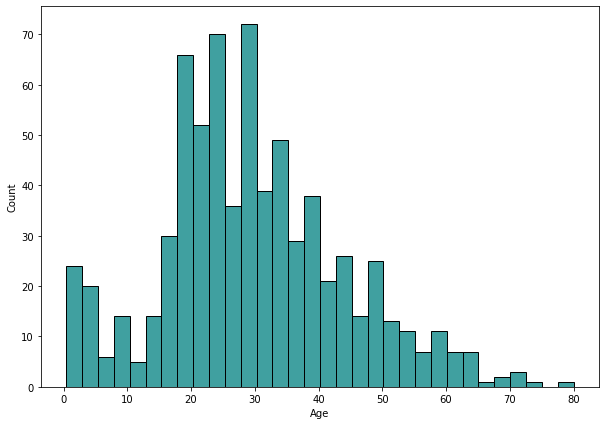

In [822]:
# Возрастное распределение пассажиров.
plt.figure(figsize=(10,7))
sns.histplot(data['Age'], stat = 'count', color = 'teal', bins = 32)
plt.show()

In [823]:
# Определение среднего значение возраста пассажиров, среднего возраста выживших и погибших пассажиров.
age_mean = data['Age'].mean()
age_mean_surv = data[(data['Survived'] == 1)]['Age'].mean()
age_mean_dec = data[(data['Survived'] == 0)]['Age'].mean()
print(' Median age of passengers:', age_mean, '\n', 'Median age of survived passengers:', age_mean_surv, '\n', 'Median age of deceased passengers:',age_mean_dec)

 Median age of passengers: 29.69911764705882 
 Median age of survived passengers: 28.343689655172415 
 Median age of deceased passengers: 30.62617924528302


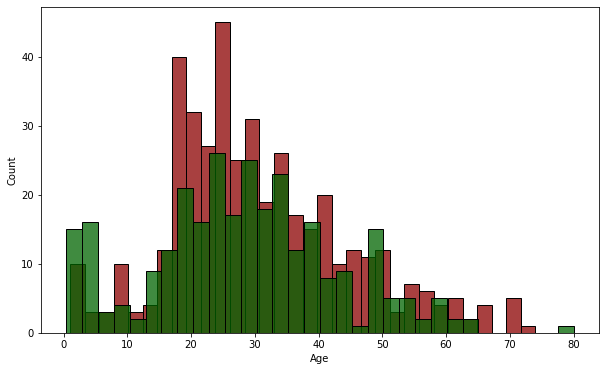

In [824]:
fig, ax = plt.subplots(figsize=(10,6))

# Возрастное распределение погибших пассажиров.
ax = sns.histplot(data[(data['Survived'] == 0)]['Age'], stat = 'count', label = 'Deceased passengers', color = 'darkred', bins = 32)

# Возрастное распределение выживших пассажиров.
ax = sns.histplot(data[(data['Survived'] == 1)]['Age'], stat = 'count', label = 'Survived passengers', color = 'darkgreen',  bins = 32)

plt.show()

Возрастное распределение выживших и умерших пассажиров примерно одинаково. Хотя мы можем заметить, что детей в возрасте от 0 до 5 лет было спасено больше, чем погибло. Это связано с тем, что детей пытались спасать в первую очередь.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [825]:
# Найдём самый безопасный класс.
Pclass = data.groupby('Pclass')['Survived'].mean().sort_values(ascending = False).index.tolist()
more_safest_Pclass = Pclass[0]
print(data.groupby('Pclass')['Survived'].mean())
print('\n', '"The safest" class:', more_safest_Pclass)

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

 "The safest" class: 1


In [826]:
# Процент выживших в каждом порту.
embarked = data.groupby('Embarked')['Survived'].mean().sort_values(ascending = False)
print(embarked * 100)

Embarked
C    55.357143
Q    38.961039
S    33.695652
Name: Survived, dtype: float64


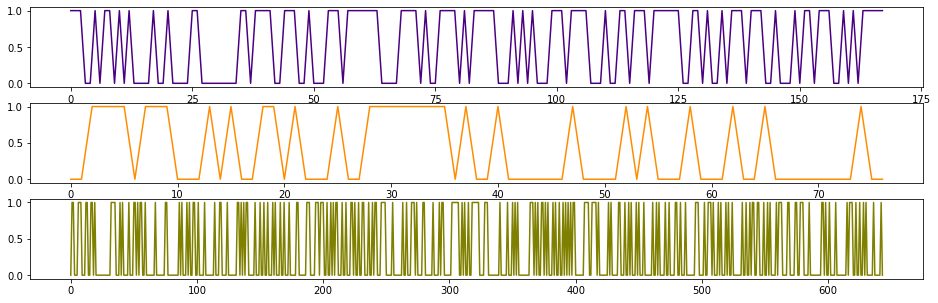

In [827]:
#Визуальзация.
fig, ax = plt.subplots(3, 1, figsize = (16, 5))

x = np.arange(0, data[(data['Embarked'] == 'C')].shape[0], 1)
y = data[(data['Embarked'] == 'C')]['Survived']
ax[0].plot (x, y, c ='indigo')

x = np.arange(0, data[(data['Embarked'] == 'Q')].shape[0], 1)
y = data[(data['Embarked'] == 'Q')]['Survived']
ax[1].plot (x, y, c ='darkorange')

x = np.arange(0, data[(data['Embarked'] == 'S')].shape[0], 1)
y = data[(data['Embarked'] == 'S')]['Survived']
ax[2].plot (x, y, c ='olive')


plt.show()


Найболее безопасны класс - первый, что не удивительно, так как в этом классенаходились более богатые люди, соответственно, что их спасение бло в приоритете.
При аналите портов посатки выяснилось, что чуть больше половиты пассажиров их порта "С" выжили, в остальных же портах выжили лишь 1/3. Однако, на мой взгляд, порт пасадки никак не мог повлиять на то, выживет ли пассажир. Вообще говоря визуализации по выживанию для каждого порта подтверждают, что нет сильного перевеса в выживании в зависимасти от порта посадки.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [828]:
data.isnull().mean() * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Больше всего значений отсутствует в коллонке с номерами кабин. Вообще говоря, эти данные могут иметь влияние, если учесть, что некоторые кабины были дальше или ближе к выходу. Однако отсутствует более 77% данных, таким обраом получаем, что лучше всего удалить эту колонкуиполностью.
Также около 19 процентов данных отсутствует в колонке с возрастами. Эта колонка является весьма важной. Но мы уже построили распределение умершив и выживших пассажиров в зависимости от возраста и увидили, что этираспределения являются схожими. Поэтому эту колонку можно откинуть так же или можно использовать метод заполнения средними значениями.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Из анализа данных ясно, что выживание не зависит от таких параметров как 'Name', 'Ticket', 'Embarked'. Так же видно, что параметр 'Fare' линейно зависим от параметра 'Pclass', поэтому один из них можно убрать.


In [829]:
# Удалим незаполненные элементы.
data_dropped = data[data.columns[data.isnull().mean() < 0.3]]
data_dropped = data_dropped.fillna(0)

# Колонка пола ('female' = 1, 'male' = 0).
data_dropped['Sex_int'] = 0
data_dropped.loc[data['Sex'] == 'female', 'Sex_int'] = 1

#Порт посадки.
data_dropped['Embarked_int'] = 0
data_dropped.loc[data['Embarked'] == 'Q', 'Embarked_int'] = 1
data_dropped.loc[data['Embarked'] == 'S', 'Embarked_int'] = 2

In [830]:
y = data_dropped['Survived']
X = data_dropped[['Pclass', 'Sex_int', 'Age',  'SibSp', 'Parch', 'Embarked_int']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 42)

In [831]:
def fit_confusion(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)

    mean, std = clf.cv_results_['mean_test_score'][clf.best_index_], \
                clf.cv_results_['std_test_score'][clf.best_index_]

    logging.info(clf.best_params_)
    
    return clf.best_estimator_, {"mean": mean, "std": std}

In [832]:
lr_param_grid = {'C': [0.01, 0.1, 1.0, 10.0],
                 'penalty': ['l1', 'l2']}

lr_clf = GridSearchCV(LogisticRegression(random_state = 42, max_iter = 1000, solver = 'saga', n_jobs =- 1), lr_param_grid)
lr_best_clf, lr_stats = fit_confusion(lr_clf, X_train, y_train, X_test, y_test)

INFO:root:{'C': 0.1, 'penalty': 'l2'}


In [833]:
y_pred = lr_best_clf.predict(X_test)
metrics.accuracy_score(y_pred = y_pred, y_true = y_test)

0.8059701492537313

KNN

In [834]:
knn_param_grid = {'n_neighbors': [1, 2, 3, 5, 30, 100], 'weights': ['uniform', 'distance']}
knn_clf = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_param_grid)

knn_best_clf, knn_stats = fit_confusion(knn_clf, X_train, y_train, X_test, y_test)

INFO:root:{'n_neighbors': 5, 'weights': 'uniform'}


In [835]:
y_pred = knn_best_clf.predict(X_test)
metrics.accuracy_score(y_pred=y_pred, y_true=y_test)

0.75

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Попробуем улучшить модель с KNN.

In [836]:
# Масштабирование данных с помощью StandardScaler().
X_scal = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scal, y, test_size = 0.3, shuffle = True, random_state = 42)

In [837]:
knn_param_grid = {'n_neighbors': [1, 2, 3, 5, 30, 100], 'weights': ['uniform', 'distance']}
knn_clf = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_param_grid)

knn_best_clf, knn_stats = fit_confusion(knn_clf, X_train, y_train, X_test, y_test)

INFO:root:{'n_neighbors': 100, 'weights': 'distance'}


In [838]:
y_pred = knn_best_clf.predict(X_test)
metrics.accuracy_score(y_pred = y_pred, y_true = y_test)

0.7723880597014925

Хотя точность модели при KNN величилась, но всё же при примерении лог. регресси точность выше.

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [839]:
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [840]:
data_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [841]:
data_test.isnull().mean() * 100

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         20.574163
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.239234
Cabin       78.229665
Embarked     0.000000
dtype: float64

In [842]:
# Удалим/заменим незаполненные элементы.
data_test_dropped = data_test[data_test.columns[data_test.isnull().mean() < 0.3]]
data_test_dropped = data_test_dropped.fillna(0)

# Колонка пола ('female' = 1, 'male' = 0).
data_test_dropped['Sex_int'] = 0
data_test_dropped.loc[data_test['Sex'] == 'female', 'Sex_int'] = 1

#Порт посадки.
data_test_dropped['Embarked_int'] = 0
data_test_dropped.loc[data_test['Embarked'] == 'Q', 'Embarked_int'] = 1
data_test_dropped.loc[data_test['Embarked'] == 'S', 'Embarked_int'] = 2

In [843]:
X_test = StandardScaler().fit_transform(data_test_dropped[['Pclass', 'Sex_int', 'Age',  'SibSp', 'Parch', 'Embarked_int']] )

In [844]:
lr_param_grid = {'C': [0.01, 0.1, 1.0, 10.0],
                 'penalty': ['l1', 'l2']}

lr_clf = GridSearchCV(LogisticRegression(random_state = 42, max_iter = 1000, solver = 'saga', n_jobs =- 1), lr_param_grid)
lr_best_clf, lr_stats = fit_confusion(lr_clf, X_train, y_train, X_test, y_test)

INFO:root:{'C': 0.01, 'penalty': 'l2'}


In [845]:
y_pred = lr_best_clf.predict(X_test)
for i in y_pred:
    print(i)

0
0
0
0
0
0
1
0
1
0
0
0
1
0
1
1
0
0
0
1
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
0
0
0
1
1
0
0
0
0
0
1
0
0
0
1
0
1
1
0
0
1
1
0
0
0
1
0
0
1
0
1
0
0
0
0
0
0
1
0
1
0
0
0
1
0
0
0
1
0
0
0
1
0
0
0
1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
1
0
1
1
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
0
1
0
0
0
0
1
0
0
1
0
1
0
1
0
1
0
1
1
0
1
0
0
0
1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
1
0
1
1
1
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
1
0
1
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
1
1
0
0
0
0
0
1
0
0
0
0
1
1
0
1
1
0
0
1
0
0
1
0
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
1
0
1
0
0
1
0
1
0
0
0
0
0
1
0
1
1
0
0
1
0
0
0


## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [846]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [847]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [848]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [849]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [850]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [851]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [852]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

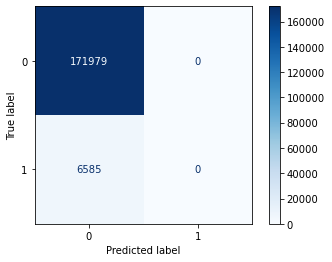

In [853]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [854]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

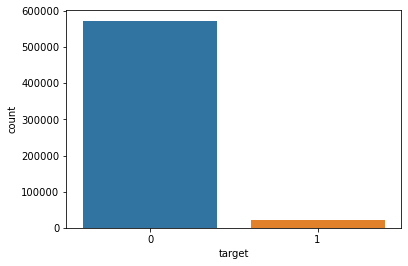

In [855]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [856]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [857]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [858]:
gini_normalized(y_valid, y_pred)

<ipython-input-856-7fd68ac4b908>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)


0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [859]:
## your code